<a href="https://colab.research.google.com/github/pythonic1exe/Sentiment-Analysis/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas matplotlib scikit-learn tensorflow nltk

In [2]:
import kagglehub, shutil, os

# 1. Download dataset
path = kagglehub.dataset_download("arkhoshghalb/twitter-sentiment-analysis-hatred-speech")
print("Downloaded to:", path)

# 2. Define destination (Colab's sample_data folder)
dest = "/content/sample_data"

# 3. Copy everything from kagglehub folder to sample_data
for file in os.listdir(path):
    src_file = os.path.join(path, file)
    dest_file = os.path.join(dest, file)
    shutil.copy(src_file, dest_file)

print("Files copied to:", dest)


100%|██████████| 1.89M/1.89M [00:00<00:00, 90.0MB/s]

Extracting files...
Downloaded to: /root/.cache/kagglehub/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech/versions/1
Files copied to: /content/sample_data


In [4]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('sample_data/train.csv')

label_col = train_df.columns[1]  # 3rd column (0-indexed)

print("Original dataset shape:", train_df.shape)
print(f"Label column: '{label_col}'")
print("Class distribution:")
print(train_df[label_col].value_counts())

# Set random seed for reproducibility
np.random.seed(42)

# Get unique class values
unique_classes = train_df[label_col].unique()
print(f"\nUnique classes: {unique_classes}")

# Sample 2000 from each class
class_samples = []
for class_val in unique_classes:
    class_data = train_df[train_df[label_col] == class_val]
    print(f"Class '{class_val}' has {len(class_data)} samples")

    if len(class_data) >= 2000:
        sampled = class_data.sample(n=2000, random_state=42)
        class_samples.append(sampled)
        print(f"Sampled 2000 from class '{class_val}'")
    else:
        print(f"Warning: Class '{class_val}' has only {len(class_data)} samples, taking all of them")
        class_samples.append(class_data)

# Combine the samples
balanced_df = pd.concat(class_samples, ignore_index=True)

# Shuffle the combined dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nBalanced dataset shape: {balanced_df.shape}")
print("Balanced class distribution:")
print(balanced_df[label_col].value_counts())

# Now use balanced_df for your NLP processing
train_df = balanced_df

Original dataset shape: (31962, 3)
Label column: 'label'
Class distribution:
label
0    29720
1     2242
Name: count, dtype: int64

Unique classes: [0 1]
Class '0' has 29720 samples
Sampled 2000 from class '0'
Class '1' has 2242 samples
Sampled 2000 from class '1'

Balanced dataset shape: (4000, 3)
Balanced class distribution:
label
0    2000
1    2000
Name: count, dtype: int64


In [5]:
train_df['label'].value_counts()

,count
label,
0,2000
1,2000


In [11]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2025-09-08 17:56:31--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove.6B.zip.2      100%[===================>] 822.24M  4.95MB/s    in 2m 39s  

2025-09-08 17:59:10 (5.16 MB/s) - ‘glove.6B.zip.2’ saved [862182613/862182613]



In [12]:
!unzip glove.6B.zip.2

Archive:  glove.6B.zip.2
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [13]:
import numpy as np

words=dict() # empty dictionary to store word embeddings

def add_to_dict(d,filename):
  with open(filename,'r') as file: # open the GloVe file
    for line in file.readlines():  # read line by line
      line = line.split(' ') # line split converts the string to a list separated by spaces

      try:
        d[line[0]] = np.array(line[1:],dtype=float) # word followed by its 50d vector representation
      except:
        continue

In [14]:
add_to_dict(words,'glove.6B.50d.txt')

In [15]:
len(words) # length of glove words

400000

In [16]:
import nltk # for natural language processing nlp

nltk.download('wordnet') # a dictionary(literal) of english words

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [17]:
tokenizer = nltk.RegexpTokenizer(r'\w+') # gives clean tokens without punctuation.

tokenizer.tokenize("@Wassup l'il boy, watchu doin?")

['Wassup', 'l', 'il', 'boy', 'watchu', 'doin']

In [18]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer() # reduces a word to its lemma which is the dictionary/base form
lemmatizer.lemmatize('feet')

'foot'

In [19]:
def message_to_token_list(s): # for tokenization and lemmatization
  tokens=tokenizer.tokenize(s)
  lowercased_tokens = [t.lower() for t in tokens] # for lowercasing
  lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens] # lemmatize the tokens in lowercased form
  useful_tokens = [t for t in lemmatized_tokens if t in words] # useful tokens are only those which also have glove vector embeddings

  return useful_tokens

message_to_token_list("hello brothers, how are ya'll doing?")

['hello', 'brother', 'how', 'are', 'ya', 'll', 'doing']

In [20]:
def message_to_word_vectors(message,word_dict=words):
  processed_list_of_tokens = message_to_token_list(message) # processed tokens

  vectors = [] # list of vectors initialized

  for token in processed_list_of_tokens: # iterate through every token processed
    if token not in word_dict: # if it is not in glove dictionary skip it
      continue

    token_vector = word_dict[token] # 50d vector embedding of the token
    vectors.append(token_vector) # add it to the list

  return np.array(vectors,dtype=float) # return the list of vectors as a numpy array

In [21]:
message_to_word_vectors("Me boy").shape # 2 words with 50d vector

(2, 50)

In [22]:
message_to_word_vectors("Me boy") # vector representation

array([[-0.14525 ,  0.31265 ,  0.15184 , -0.63708 ,  0.63553 , -0.50295 ,
        -0.23214 ,  0.52892 , -0.58629 ,  0.53935 , -0.3055  ,  1.0357  ,
        -0.77989 , -0.19387 ,  1.2215  ,  0.24521 ,  0.26144 ,  0.22439 ,
         0.15584 , -0.79146 , -0.65262 ,  1.3211  ,  0.76618 ,  0.38234 ,
         1.4453  , -2.2643  , -1.1505  ,  0.50373 ,  1.2651  , -1.5903  ,
         3.0518  ,  0.84118 , -0.69543 ,  0.29985 , -0.49151 , -0.22312 ,
         0.59528 , -0.076347,  0.52358 , -0.50134 ,  0.22483 ,  0.01546 ,
        -0.088005,  0.21282 ,  0.28545 , -0.15976 , -0.16777 , -0.50895 ,
         0.14322 ,  1.0118  ],
       [-0.32345 ,  0.23332 , -0.20082 , -0.52848 ,  1.0926  ,  0.62445 ,
        -0.99859 ,  0.28085 ,  0.088326,  0.36919 ,  0.32199 ,  0.3499  ,
         0.067459,  0.24211 ,  0.92565 , -0.32581 , -0.99134 ,  0.80767 ,
        -0.22845 ,  0.40076 , -0.8577  ,  1.3836  ,  0.056439,  0.76561 ,
         0.3608  , -2.0692  , -0.46679 ,  0.12359 ,  0.35127 , -0.77092 ,
       

In [23]:
# train_df is the variable(df) where we loaded the dataset in the very start
train_df = train_df.sample(frac=1,random_state=1) # shuffle data
train_df.reset_index(drop=True, inplace=True) # re-indexing

split_index_1 = int(len(train_df) * 0.7) #70%
split_index_2 = int(len(train_df) * 0.85) #85%

# training: 70%, validation: 15%, testing: 15%
train_df, val_df, test_df = train_df[:split_index_1], train_df[split_index_1:split_index_2], train_df[split_index_2:]

len(train_df), len(val_df), len(test_df)

(2800, 600, 600)

In [24]:
# convert dataset to vector form
def df_to_X_y(dff):
  # target y
  y = dff['label'].to_numpy().astype(int) # convert the labels to numpy array of integers

  all_word_vector_sequences = [] # list for storing vector embeddings of all the words in dataset

  for message in dff['tweet']: # iterate through every message in the dataset
    message_as_vector_seq = message_to_word_vectors(message) # convert the tweet/message to vector form

    if message_as_vector_seq.shape[0]==0: # if no known tokens in glove
      message_as_vector_seq = np.zeros(shape=(1,50)) # write a simple numpy array of 0, 50d, of 1 row

    all_word_vector_sequences.append(message_as_vector_seq) # append to list

  return all_word_vector_sequences, y

In [25]:
X_train, y_train = df_to_X_y(train_df)

print(len(X_train), len(X_train[0])) # length of training dataset portion and length of first message


2800 9


(array([154., 485., 539., 708., 431., 329., 125.,  24.,   3.,   2.]),
 array([ 1. ,  4.6,  8.2, 11.8, 15.4, 19. , 22.6, 26.2, 29.8, 33.4, 37. ]),
 <BarContainer object of 10 artists>)

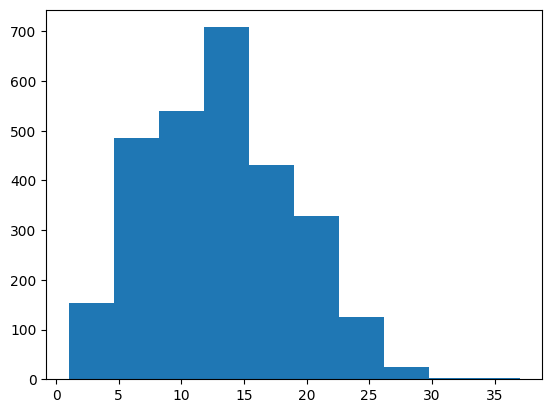

In [26]:
sequence_length = []

for i in range(len(X_train)): # iterate through whole dataset
  sequence_length.append(len(X_train[i])) # append the word length of ith message to list

import matplotlib.pyplot as plt

# this is to check the word lengths of each message
plt.hist(sequence_length) # histogram

In [27]:
pd.Series(sequence_length).describe() # tell the facts of the whole X_train dataset

,0
count,2800.000000
mean,13.021786
std,5.626383
min,1.000000
25%,9.000000
50%,13.000000
75%,17.000000
max,37.000000


In [28]:
# we need every sentence to be of same length because otherwise it will be hard to
# convert to numpy array. So, we will increase the length by adding 0 in place so that
# required length is matched. We set the length to max 57

from copy import deepcopy # for copying

def pad_X(X,desired_sequnece_length=40):
  X_copy = deepcopy(X) # deepcopy of X which is the dataset

  for i, x in enumerate(X): # as every message length different use enumerate to iterate accordingly
    x_seq_length = x.shape[0] # length of message
    sequence_length_difference = desired_sequnece_length - x_seq_length

    pad = np.zeros(shape=(sequence_length_difference,50)) # create a numpy of 0s of size sequence_length_difference

    X_copy[i] = np.concatenate([x,pad]) # concatnate the message with 0 padding so required length is matched

  return np.array(X_copy).astype(float) # return the padded array and convert to type float

In [29]:
# for 70% training dataset
X_train = pad_X(X_train)

X_train.shape # every message is now of same length

(2800, 40, 50)

In [30]:
# for 15% validation dataset
X_val, y_val = df_to_X_y(val_df) # convert to vector
X_val = pad_X(X_val) # zero padding

X_val.shape, y_val.shape

((600, 40, 50), (600,))

In [31]:
# for 15% testing dataset
X_test, y_test = df_to_X_y(test_df) # convert to vector
X_test = pad_X(X_test) # zero padding

X_test.shape, y_test.shape

((600, 40, 50), (600,))

In [33]:
# LSTM model
import tensorflow
from tensorflow import keras
from keras import layers
from keras.models import Sequential

model = Sequential([]) # a Sequential model which is a stack of layers applied one after the other.

model.add(layers.Input(shape=(40, 50))) # each input is of words 40 and 50d
model.add(layers.LSTM(64, return_sequences=True)) # 1st lstm layer with 64 hidden units
model.add(layers.Dropout(0.2)) # randmoly drop 20% neurons for regularization
model.add(layers.LSTM(64, return_sequences=True)) # 2nd layer
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True)) # 3rd layer
model.add(layers.Dropout(0.2))
model.add(layers.Flatten()) # takes output of sequnce and flattens it to single vector, helps in dense layer
model.add(layers.Dense(1, activation='sigmoid')) # dense layer outputs 1 or 0 through sigmoid function

In [34]:
# how model will learn
from keras.losses import BinaryCrossentropy # loss function
from keras.optimizers import Adam # optimizer for how weights are updated
from keras.metrics import AUC # a metric for imbalanced data
from keras.callbacks import ModelCheckpoint # callback to save model

cp = ModelCheckpoint('model/best_model.keras',save_best_only= True) # for saving model, only will be saved once validation improves

model.compile(optimizer = Adam(learning_rate=0.0001), # model with Adam optimizer
              loss = BinaryCrossentropy(), # loss functiom
              metrics = ['accuracy', AUC(name='AUC')]) # metrics of model


In [35]:
frequencies = pd.value_counts(train_df['label'])

frequencies # how many example of each label in X_train

/tmp/ipython-input-2014568285.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  frequencies = pd.value_counts(train_df['label'])


,count
label,
1,1411
0,1389


In [36]:
# as our dataset is imbalanced, we set the weights accordingly, giving higher weights to rare class
weights = {
    0: frequencies.sum() / frequencies[0], # weight of non hatred
    1: frequencies.sum() / frequencies[1] # weight of hatred
}

weights

{0: np.float64(2.015838732901368), 1: np.float64(1.984408221119773)}

In [37]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp], class_weight=weights) # train model

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - AUC: 0.5902 - accuracy: 0.5677 - loss: 1.3770 - val_AUC: 0.7738 - val_accuracy: 0.6917 - val_loss: 0.6475
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - AUC: 0.8163 - accuracy: 0.7507 - loss: 1.1420 - val_AUC: 0.8488 - val_accuracy: 0.7600 - val_loss: 0.4872
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - AUC: 0.8858 - accuracy: 0.8098 - loss: 0.8576 - val_AUC: 0.8697 - val_accuracy: 0.7750 - val_loss: 0.4542
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - AUC: 0.8862 - accuracy: 0.8075 - loss: 0.8498 - val_AUC: 0.8721 - val_accuracy: 0.7883 - val_loss: 0.4540
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - AUC: 0.9075 - accuracy: 0.8280 - loss: 0.7732 - val_AUC: 0.8798 - val_accuracy: 0.7767 - val_loss: 0.4637
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - AUC: 0.9043 - accuracy: 0.8208 - loss: 0.7914 - val_AUC: 0.8816 - val_accuracy: 0.8000 - val_loss: 0.4364
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 95

In [ ]:
# 1 epoch is one full pass of the training dataset through the model.

In [38]:
from keras.models import load_model

best_model = load_model('model/best_model.keras')

In [39]:
test_predictions = (best_model.predict(X_test) > 0.5).astype(int)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [40]:
from sklearn.metrics import classification_report

print(classification_report(y_test,test_predictions))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       291
           1       0.88      0.83      0.86       309

    accuracy                           0.85       600
   macro avg       0.86      0.86      0.85       600
weighted avg       0.86      0.85      0.86       600



In [58]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
from copy import deepcopy
import os

# configuration of Streamlit page
st.set_page_config(
    page_title="Hate Speech Detection",
    page_icon="🛡️",
    layout="centered",
    initial_sidebar_state="collapsed"
)

# functions
@st.cache_data
# nltk data
def download_nltk_data():
    try:
        import nltk
        nltk.download('wordnet')
    except ImportError:
        st.warning("NLTK not available.")

@st.cache_resource
# GloVe embeddings
def load_glove_embeddings(filename):
  words = dict()
  with open(filename,'r') as file: # open the GloVe file
    for line in file.readlines():  # read line by line
      line = line.split(' ') # line split converts the string to a list separated by spaces

      try:
        words[line[0]] = np.array(line[1:],dtype=float) # word followed by its 50d vector representation
      except:
        continue

    return words

@st.cache_resource
# LSTM trained model
def load_hate_speech_model():
  from keras.models import load_model
  return load_model('model/best_model.keras')

# defined functions of model in app.py :

def message_to_token_list(s, words):
    tokens = s.lower().split()
    useful_tokens = [t for t in tokens if t in words]
    return useful_tokens

def message_to_word_vectors(message, word_dict):
    tokens = message_to_token_list(message, word_dict)
    vectors = []

    for token in tokens:
        if token in word_dict:
            vectors.append(word_dict[token])

    if not vectors:
        return np.zeros((1, 50))
    return np.array(vectors, dtype=float)

def pad_X(X, desired_sequence_length=40):
    X_copy = deepcopy(X)
    x_seq_length = X.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_length

    if sequence_length_difference > 0:
        pad = np.zeros(shape=(sequence_length_difference, 50))
        X_copy = np.concatenate([X, pad])
    elif sequence_length_difference < 0:
        X_copy = X[:desired_sequence_length]

    return X_copy.astype(float)

# prediction of hate speech
def predict_hate_speech(text, model, words):
    try:
        message_vectors = message_to_word_vectors(text, words)

        if message_vectors.shape[0] == 0:
            message_vectors = np.zeros(shape=(1, 50))

        padded_vectors = pad_X(message_vectors, 40)
        model_input = padded_vectors.reshape(1, 40, 50)
        prediction = model.predict(model_input, verbose=0)[0][0]

        return float(prediction)

    except Exception as e:
        st.error(f"Prediction error: {str(e)}")
        return 0.0

def main():
    # load nltk data
    download_nltk_data()

    try:
        words = load_glove_embeddings('glove.6B.50d.txt') # GloVe embeddings
        model = load_hate_speech_model() # model
    except Exception as e:
        st.error(f"Error loading model resources: {str(e)}")
        st.stop()

    # custom CSS
    st.markdown("""
    <style>
    .main {
        padding-top: 2rem;
    }
    .stTextArea textarea {
        font-size: 16px !important;
        min-height: 120px !important;
    }
    .prediction-box {
        padding: 1rem;
        border-radius: 10px;
        margin: 1rem 0;
        text-align: center;
        font-size: 18px;
        font-weight: bold;
    }
    .hate-speech {
        background-color: #ffebee;
        border: 2px solid #f44336;
        color: #c62828;
    }
    .no-hate-speech {
        background-color: #e8f5e8;
        border: 2px solid #4caf50;
        color: #2e7d32;
    }
    </style>
    """, unsafe_allow_html=True)

    # header
    st.title("🛡️ Hate Speech Detection")
    st.markdown("**AI-powered text analysis using LSTM + GloVe embeddings**")
    st.markdown("---")

    # model info
    col1, col2, col3, col4 = st.columns(4)

    with col1:
        st.metric("Accuracy", "85%", "High")
    with col2:
        st.metric("Model Type", "LSTM", "3 Layers")
    with col3:
        st.metric("Embeddings", "GloVe", "50D")
    with col4:
        st.metric("Sequence", "40", "Words")

    st.markdown("---")

    # input section
    st.subheader("📝 Enter Text to Analyze")
    user_input = st.text_area(
        "Type or paste your text here:",
        placeholder="Enter any text you'd like to analyze for hate speech...",
        help="The model will analyze your text and determine if it contains hate speech"
    )

    # analysis section
    col1, col2, col3 = st.columns([1, 2, 1])

    with col2:
        if st.button("🔍 Analyze Text", use_container_width=True, type="primary"):
            if user_input.strip():
                with st.spinner("Analyzing text..."):
                    prediction_score = predict_hate_speech(user_input, model, words)

                    is_hate_speech = prediction_score > 0.5
                    confidence = prediction_score if is_hate_speech else (1 - prediction_score)

                    st.markdown("---")
                    st.subheader("📊 Analysis Results")

                    if is_hate_speech:
                        st.markdown(f"""
                        <div class="prediction-box hate-speech">
                            ⚠️ HATE SPEECH DETECTED<br>
                            <small>This text appears to contain hate speech content</small>
                        </div>
                        """, unsafe_allow_html=True)
                    else:
                        st.markdown(f"""
                        <div class="prediction-box no-hate-speech">
                            ✅ NO HATE SPEECH DETECTED<br>
                            <small>This text appears to be safe and non-harmful</small>
                        </div>
                        """, unsafe_allow_html=True)

                    col_conf1, col_conf2 = st.columns(2)

                    with col_conf1:
                        st.metric("Confidence Level", f"{confidence:.1%}")

                    with col_conf2:
                        st.metric("Raw Score", f"{prediction_score:.4f}")

                    st.progress(confidence)

                    with st.expander("🔧 Technical Details"):
                        tokens = message_to_token_list(user_input, words)
                        original_words = len(user_input.split())
                        processed_tokens = len(tokens)

                        col_tech1, col_tech2 = st.columns(2)

                        with col_tech1:
                            st.write(f"**Original words:** {original_words}")
                            st.write(f"**Processed tokens:** {processed_tokens}")
                            st.write(f"**Classification threshold:** 0.5")

                        with col_tech2:
                            st.write(f"**Model architecture:** 3-layer LSTM")
                            st.write(f"**Sequence length:** 40 words (padded)")
                            st.write(f"**Vector dimension:** 50D GloVe")

                        if tokens:
                            st.write(f"**Sample tokens:** {', '.join(tokens[:10])}")
                        else:
                            st.write("**Note:** No tokens found in vocabulary")
            else:
                st.warning("⚠️ Please enter some text to analyze.")

    # information section
    st.markdown("---")
    st.subheader("ℹ️ About This Model")

    col_info1, col_info2 = st.columns(2)

    with col_info1:
        st.markdown("""
        **🧠 Model Architecture:**
        - 3-layer LSTM network
        - 64 hidden units per layer
        - Dropout regularization (0.2)
        - Sigmoid output activation

        **📊 Training:**
        - Balanced dataset (4,000 samples)
        - 70% train, 15% validation, 15% test
        - Class weight balancing applied
        """)

    with col_info2:
        st.markdown("""
        **⚙️ Text Processing:**
        - NLTK tokenization & lemmatization
        - GloVe 6B.50d word embeddings
        - 40-word sequence padding
        - Binary classification (hate/no-hate)

        **🔒 Privacy:**
        - All processing done locally
        - No data stored or logged
        - Instant analysis results
        """)

    # footer
    st.markdown("---")
    st.markdown(
        "<div style='text-align: center; color: #666; padding: 1rem;'>"
        "Built with TensorFlow, LSTM, and Streamlit | Hate Speech Detection AI"
        "</div>",
        unsafe_allow_html=True
    )

if __name__ == "__main__":
    main()

Overwriting app.py


In [59]:
%%writefile run_tunnel.py
import subprocess
import threading
import time
import os
import signal
import sys

# for running streamlit server
def run_streamlit():
    print("Starting Streamlit server...")
    try:
        subprocess.run([
            "streamlit", "run", "app.py",
            "--server.port", "8501",
            "--server.headless", "true",
            "--server.enableCORS", "false",
            "--server.enableXsrfProtection", "false"
        ])
    except KeyboardInterrupt:
        print("Streamlit stopped by user")

# for checking if the port is already in use
def check_port(port):
    result = subprocess.run(['netstat', '-tulpn'], capture_output=True, text=True)
    return str(port) in result.stdout

def main():
    print("🚀 Starting Hate Speech Detection App with Cloudflare Tunnel")
    print("=" * 60)

    # kill any existing processes so that streamlit runs easily
    print("Cleaning up existing processes...")
    subprocess.run(['pkill', '-f', 'streamlit'], capture_output=True)
    subprocess.run(['pkill', '-f', 'cloudflared'], capture_output=True)
    time.sleep(2)

    # check if app.py exists
    if not os.path.exists('app.py'):
        print("❌ app.py not found! Please create your Streamlit app file first.")
        return

    # start Streamlit in background because it doesnt run on colab locally
    streamlit_thread = threading.Thread(target=run_streamlit, daemon=True)
    streamlit_thread.start()

    # wait few seconds for Streamlit to start
    print("Waiting for Streamlit to start...")
    for i in range(15):
        time.sleep(1)
        if check_port(8501):
            print("✅ Streamlit is running on port 8501")
            break
        print(f"Waiting... ({i+1}/15)")
    else:
        print("❌ Streamlit failed to start on port 8501")
        return

    # start Cloudflare tunnel
    print("\nStarting Cloudflare tunnel...")
    print("This will show your public URL below:")
    print("-" * 40)

    try:
        # run cloudflared in foreground to see the URL
        subprocess.run([
            "cloudflared", "tunnel",
            "--url", "http://localhost:8501"
        ])
    except KeyboardInterrupt:
        print("\n\nShutting down...")
        subprocess.run(['pkill', '-f', 'streamlit'], capture_output=True)
        subprocess.run(['pkill', '-f', 'cloudflared'], capture_output=True)
        print("All processes stopped. Goodbye!")

if __name__ == "__main__":
    main()

Overwriting run_tunnel.py


In [61]:
# install cloudfare
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb

!pip install streamlit

# run the tunnel script
!python run_tunnel.py

(Reading database ... 126378 files and directories currently installed.)
Preparing to unpack cloudflared-linux-amd64.deb ...
Unpacking cloudflared (2025.8.1) over (2025.8.1) ...
Setting up cloudflared (2025.8.1) ...
Processing triggers for man-db (2.10.2-1) ...
🚀 Starting Hate Speech Detection App with Cloudflare Tunnel
Cleaning up existing processes...
Starting Streamlit server...
Waiting for Streamlit to start...
Waiting... (1/15)


✅ Streamlit is running on port 8501

Starting Cloudflare tunnel...
This will show your public URL below:
----------------------------------------

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://104.199.122.226:8501

2025-09-08T21:52:33Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject t